In [ ]:
!pip install hampel
import numpy as np
from joblib import Parallel, delayed
import pandas as pd
import torch
import torch.nn.functional as F
import math
from scipy import signal
import os
import argparse
import matplotlib.pyplot as plt
from PIL import Image
# from scipy import signal
import torch
from scipy import stats
from scipy.signal import medfilt
from hampel import hampel
import numpy as np

Đã đọc 640004 phần tử từ tệp.
Tensor radar có kích thước: (128, 5000)
(1970+2040j)
(128, 5000)


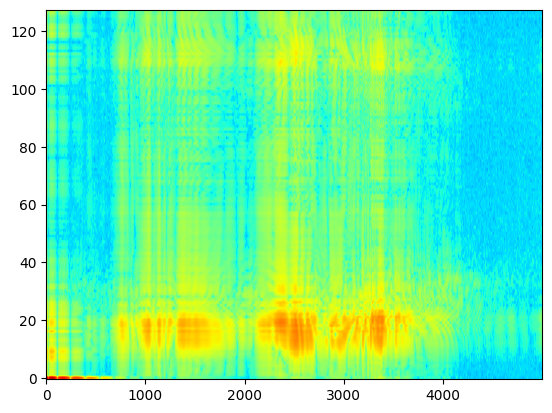

In [ ]:
import numpy as np
import cmath

file_path = '/kaggle/input/glasgow/3 June 2017 Dataset/2P32A02R1.dat'

radar_data_raw = []

try:
    with open(file_path, 'r') as fileID:
        for line in fileID:
            elements = line.strip().split()
            for item in elements:
                # Thử chuyển đổi thành số phức trước, sau đó số thực
                if 'i' in item or 'j' in item:
                    try:
                        radar_data_raw.append(complex(item.replace('i', 'j')))
                    except ValueError as e:
                        print(f"Lỗi chuyển đổi số phức: '{item}' - {e}")
                else:
                    try:
                        radar_data_raw.append(float(item))
                    except ValueError as e:
                        print(f"Lỗi chuyển đổi số thực: '{item}' - {e}")

except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp tại đường dẫn: {file_path}")
    exit()
except Exception as e:
    print(f"Lỗi chung khi đọc tệp: {e}")
    exit()

print(f"Đã đọc {len(radar_data_raw)} phần tử từ tệp.")

if not radar_data_raw or len(radar_data_raw) < 3:
    print("Lỗi: Không có đủ dữ liệu tham số trong tệp.")
    exit()

NTS = int(radar_data_raw[2].real) if isinstance(radar_data_raw[2], complex) else int(radar_data_raw[2])

if len(radar_data_raw) > 4:
    iq_data = np.array(radar_data_raw[4:])
    num_samples = len(iq_data)
    if NTS > 0 and num_samples % NTS == 0:
        num_chirps = num_samples // NTS
        radar_tensor = iq_data.reshape((NTS, num_chirps), order='F') # Reshape theo thứ tự Fortran (column-major)
        print("Tensor radar có kích thước:", radar_tensor.shape)
        # Bây giờ bạn có tensor 'radar_tensor' chứa dữ liệu IQ đã sắp xếp
    else:
        print(f"Lỗi: Không thể định hình dữ liệu IQ. NTS = {NTS}, số mẫu = {num_samples}. Số mẫu không chia hết cho NTS.")
        radar_tensor = None
else:
    print("Lỗi: Không có dữ liệu IQ trong tệp.")
    radar_tensor = None

# raw = radar_tensor[:,center_start:center_end]
raw = radar_tensor[:,:5000] 
# print(raw.shape)
print(raw[0,0])
tmp = np.fft.fft(raw, axis=0)
# tmp = tmp[:raw.shape[0] // 2, :]
b, a = signal.butter(4, 0.0075, 'high') 
Data_range_MTI = signal.lfilter(b,a,tmp, axis=1)  
# Data_range_MTI = Data_range_MTI[:, center_start:center_end]
Range_time = 20* np.log10(np.abs(Data_range_MTI))
print(Data_range_MTI.shape)
im = plt.imshow(
    Range_time, 
    aspect='auto', 
    cmap='jet', 
    origin='lower',
)
# _, __, micro_Doppler = signal.stft(Data_range_MTI[0:80,:],nperseg=256,noverlap=128,nfft=256, boundary=None, padded=False, return_onesided=False)
# # _, __, micro_Doppler = signal.spectrogram(Data_range_MTI[0:80,:],nperseg=256,noverlap=128,nfft=256,return_onesided=False)
# micro_Doppler = np.sum(np.abs(micro_Doppler), axis=0) 
# micro_Doppler = np.fft.fftshift(micro_Doppler, axes=0)
# micro = 20*np.log10(np.abs(micro_Doppler))
# print(micro.shape)
# im = plt.imshow(
#     micro, 
#     aspect='auto', 
#     cmap='jet', 
#     origin='lower',
# )
# 'radar_tensor' chứa dữ liệu IQ đã được sắp xếp thành tensor (NTS x num_chirps)
# Bạn có thể sử dụng 'radar_tensor' cho các bước xử lý tiếp theo của mình.

In [2]:
def iqr_sliding_window(data, window_size):
    n = len(data)
    cleaned_data = np.copy(data)  # Tạo bản sao để giữ dữ liệu đã xử lý

    for i in range(n - window_size + 1):
        # Trích xuất cửa sổ
        window = data[i:i + window_size]

        # Tính Q1, Q3 và IQR
        Q1 = np.percentile(window, 25)
        Q3 = np.percentile(window, 75)
        IQR = Q3 - Q1

        # Xác định ngưỡng trên và dưới
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Tìm giá trị ngoại lệ trong cửa sổ
        for j in range(i, i + window_size):
            if data[j] < lower_bound or data[j] > upper_bound:
                # Thay thế ngoại lệ bằng giá trị trung vị của cửa sổ
                cleaned_data[j] = np.median(window)
    return cleaned_data

In [29]:
from scipy.signal import savgol_filter
def data_preprocessing(file_path):
    radar_data_raw = []
    try:
        with open(file_path, 'r') as fileID:
            for line in fileID:
                elements = line.strip().split()
                for item in elements:
                    # Thử chuyển đổi thành số phức trước, sau đó số thực
                    if 'i' in item or 'j' in item:
                        try:
                            radar_data_raw.append(complex(item.replace('i', 'j')))
                        except ValueError as e:
                            print(f"Lỗi chuyển đổi số phức: '{item}' - {e}")
                    else:
                        try:
                            radar_data_raw.append(float(item))
                        except ValueError as e:
                            print(f"Lỗi chuyển đổi số thực: '{item}' - {e}")
    
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy tệp tại đường dẫn: {file_path}")
        exit()
    except Exception as e:
        print(f"Lỗi chung khi đọc tệp: {e}")
        exit()
    
    print(f"Đã đọc {len(radar_data_raw)} phần tử từ tệp.")
    
    if not radar_data_raw or len(radar_data_raw) < 3:
        print("Lỗi: Không có đủ dữ liệu tham số trong tệp.")
        exit()
    
    NTS = int(radar_data_raw[2].real) if isinstance(radar_data_raw[2], complex) else int(radar_data_raw[2])
    
    if len(radar_data_raw) > 4:
        iq_data = np.array(radar_data_raw[4:])
        num_samples = len(iq_data)
        if NTS > 0 and num_samples % NTS == 0:
            num_chirps = num_samples // NTS
            radar_tensor = iq_data.reshape((NTS, num_chirps), order='F') # Reshape theo thứ tự Fortran (column-major)
            print("Tensor radar có kích thước:", radar_tensor.shape)
            # Bây giờ bạn có tensor 'radar_tensor' chứa dữ liệu IQ đã sắp xếp
        else:
            print(f"Lỗi: Không thể định hình dữ liệu IQ. NTS = {NTS}, số mẫu = {num_samples}. Số mẫu không chia hết cho NTS.")
            radar_tensor = None
    else:
        print("Lỗi: Không có dữ liệu IQ trong tệp.")
        radar_tensor = None

        
    Data_time = radar_tensor[:,:5000] 

    tmp = np.fft.fft(Data_time, axis=0)
    tmp_flipped=tmp[:,::-1]
    b, a = signal.butter(4, 0.0075, 'high')  
    # sos=signal.butter(5, 0.0075, 'low', output='sos')
    # Perform Range_time
    Data_range_MTI = signal.lfilter(b,a,tmp, axis=1)   
    Data_range_MTI1 = signal.lfilter(b,a,tmp_flipped, axis=1)[:,::-1]
    Data_range_MTI_=np.where(np.abs(Data_range_MTI)<np.abs(Data_range_MTI1),Data_range_MTI, Data_range_MTI1)

    #Filter choese range_bin ###########################
    frame = 128
    nover = 25
    segment = 1
    c = 1
    h=1
    
    entropy_process_2 = np.copy(Data_range_MTI_[:, 0: (np.size(Data_range_MTI, 1) // (nover * segment)) * (nover * segment)])
    num_segments = np.size(entropy_process_2, 1) // (nover * segment)
    num_rows = np.size(entropy_process_2, 0)
    
    # Vector hóa tính toán seg_mag
    seg_mag = 20*np.log10(np.abs(entropy_process_2[:, :num_segments * nover * segment]).reshape(num_rows, num_segments, nover * segment) + 1e-8)
    seg_proba = np.abs(seg_mag / np.sum(seg_mag, axis=2, keepdims=True))
    seg_entropy = -np.sum(seg_proba * np.log(seg_proba + 1e-8), axis=2)  
    
    seg_entropy = np.sum(seg_mag, axis=2)  # shape: (128, 170)
    compare = np.percentile(seg_entropy, 99, axis=0)  # shape: (170,)
    mask = seg_entropy > compare  # broadcasting OK: (128,170) > (170,)

    index_nearest = np.full(num_segments, -1)
    valid_mask = np.any(mask, axis=0)
    index_nearest[np.where(valid_mask)[0]] = np.argmax(mask[:, valid_mask], axis=0)
    
            
    # Tính entropy_array và tìm chỉ số max
    entropy_array = np.where(mask, np.sum(np.abs(entropy_process_2[:, :num_segments * nover * segment]).reshape(num_rows, num_segments, nover * segment), axis=2), 0)
    index_max = np.argmax(entropy_array, axis=0)
    
    result = hampel(np.array(index_nearest), window_size=50, n_sigma=3.0)
    index_nearest = np.round(result.filtered_data).astype(int)
    result = hampel(np.array(index_nearest), window_size=5, n_sigma=3.0)
    index_nearest = np.round(result.filtered_data).astype(int)
    result = hampel(np.array(index_nearest), window_size=25, n_sigma=3.0)
    index_nearest = np.round(result.filtered_data).astype(int)
    index_nearest = iqr_sliding_window(np.array(index_nearest), window_size= 50)
    index_nearest = savgol_filter(index_nearest, window_length=99 ,polyorder=2)  # Điều chỉnh thông số nếu cần
    index_nearest = np.round(index_nearest).astype(int)


    if np.min(index_nearest) <10:
        bin_indl = 0
    else:
        bin_indl = np.min(index_nearest) -10
    if np.max(index_nearest) >118:
        bin_indu = 128
    else:
        bin_indu = np.max(index_nearest)+10
    print(bin_indl)
    print(bin_indu)

    Range_time_filter = Data_range_MTI*0+1
    for i in range(np.size(index_nearest)):
        for j in range(np.size(Range_time_filter, 1)//h):
            if j == index_nearest[i] and j*h>10 and (j+1)*h+10<128 :
                Range_time_filter[j*h-10: (j+1)*h+10, i*c*nover*segment:(i+1)*c*nover*segment] = Data_range_MTI[j*h-10: (j+1)*h+10, i*c*nover*segment:(i+1)*c*nover*segment]
            else:
                if j == index_nearest[i] and (j+1)*h+10<128 :
                    Range_time_filter[0: (j+1)*h+5, i*c*nover*segment:(i+1)*c*nover*segment] = Data_range_MTI[0: (j+1)*h+5, i*c*nover*segment:(i+1)*c*nover*segment]

    # _, __, micro_doppler = signal.stft(Range_time_filter[5:35,:],nperseg=256,noverlap=128,nfft=256, boundary=None, padded=False, return_onesided=False)
    _, __, micro_doppler = signal.spectrogram(Range_time_filter[5:35,:],nperseg=256,noverlap=128,nfft=256,return_onesided=False)
    md_ft_col = micro_doppler

    #thresould#################
    micro_doppler_mean = np.mean(np.abs(md_ft_col), axis=1, keepdims = True)
    # Tạo một mảng điều kiện để áp dụng ngưỡng
    threshold =  0* (micro_doppler_mean)

    #Áp dụng điều kiện trên toàn bộ mảng cùng một lúc
    md_ft_col = np.where(
        np.abs(md_ft_col) > threshold,
        np.abs(md_ft_col),
        1
    )
    md_ft_col = np.sum(md_ft_col, axis = 0)
    md_ft_col = np.flipud(np.fft.fftshift(md_ft_col, axes=0))
    ###########################
     
    # _, __, micro_Doppler = signal.stft(Data_range_MTI[0:50,:],nperseg=256,noverlap=128,nfft=256, boundary=None, padded=False, return_onesided=False)
    _, __, micro_Doppler = signal.spectrogram(Data_range_MTI[0:50,:],nperseg=256,noverlap=128,nfft=256,return_onesided=False)
    micro_Doppler = np.sum(np.abs(micro_Doppler), axis=0) 
    micro_Doppler = np.fft.fftshift(micro_Doppler, axes=0)
    # return Range_time_filter
    return Data_range_MTI
    # return md_ft_col
    # return micro_Doppler


Đã đọc 640004 phần tử từ tệp.
Tensor radar có kích thước: (128, 5000)
7
30
(128, 5000)
Execution Time: 1.1664 seconds
(128, 5000)


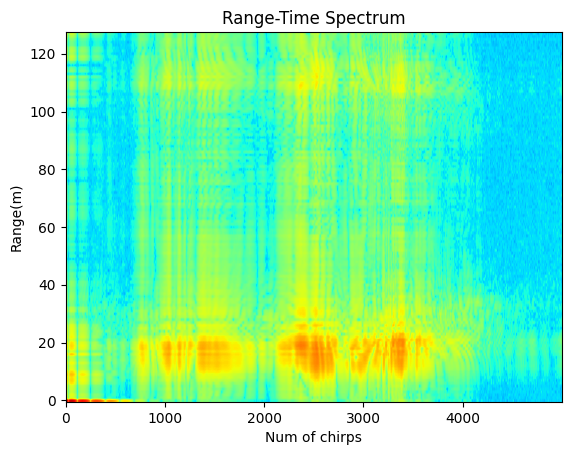

In [30]:
import time

start_time = time.time()

md= data_preprocessing('/kaggle/input/glasgow/3 June 2017 Dataset/2P32A02R1.dat')
# md = np.load('/kaggle/working/processed_data/1_11_135_1_1.npz')['x']
print(md.shape)
md = 20*np.log10(np.abs(md))
# md = 20*np.log10(np.abs(md))
# md = (md-np.min(md))/(np.max(md)-np.min(md))
end_time = time.time()
execution_time = end_time - start_time
# md = md / (np.linalg.norm(md, axis=0, keepdims = True)+1e-8)
# md = (md-np.min(md))/(np.max(md)-np.min(md))
print(f"Execution Time: {execution_time:.4f} seconds")
print(md.shape)
im = plt.imshow(
    md, 
    aspect='auto', 
    cmap='jet', 
    origin='lower',
)
# plt.colorbar(label='Amplitude')
# plt.xlabel("Time")
# plt.ylabel("Velocity")
# plt.title("Micro-Doppler Spectrum")
clim = im.get_clim()
# im.set_clim(clim[1]*0.01, clim[1])
im.set_clim(clim[0], clim[1])
plt.xlabel("Num of chirps")
plt.ylabel("Range(m)")
plt.title("Range-Time Spectrum")
plt.show()

# md = md / (np.linalg.norm(md, axis=0, keepdims = True)+1e-8)

In [44]:
import re
def data_preprocessing(file_path):
    
    file_name = file_path.split('/')[-1]  # '1P36A01R01.dat'

    # Dùng regex để lấy label giữa A và R
    match = re.search(r'A(\d+)R', file_name)
    if match:
        label = int(match.group(1))
    else:
        label = None  # hoặc raise Exception("Không tìm thấy nhãn")
        
    radar_data_raw = []
    try:
        with open(file_path, 'r') as fileID:
            for line in fileID:
                elements = line.strip().split()
                for item in elements:
                    # Thử chuyển đổi thành số phức trước, sau đó số thực
                    if 'i' in item or 'j' in item:
                        try:
                            radar_data_raw.append(complex(item.replace('i', 'j')))
                        except ValueError as e:
                            print(f"Lỗi chuyển đổi số phức: '{item}' - {e}")
                    else:
                        try:
                            radar_data_raw.append(float(item))
                        except ValueError as e:
                            print(f"Lỗi chuyển đổi số thực: '{item}' - {e}")
    
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy tệp tại đường dẫn: {file_path}")
        exit()
    except Exception as e:
        print(f"Lỗi chung khi đọc tệp: {e}")
        exit()
    
    print(f"Đã đọc {len(radar_data_raw)} phần tử từ tệp.")
    
    if not radar_data_raw or len(radar_data_raw) < 3:
        print("Lỗi: Không có đủ dữ liệu tham số trong tệp.")
        exit()
    
    NTS = int(radar_data_raw[2].real) if isinstance(radar_data_raw[2], complex) else int(radar_data_raw[2])
    
    if len(radar_data_raw) > 4:
        iq_data = np.array(radar_data_raw[4:])
        num_samples = len(iq_data)
        if NTS > 0 and num_samples % NTS == 0:
            num_chirps = num_samples // NTS
            radar_tensor = iq_data.reshape((NTS, num_chirps), order='F') # Reshape theo thứ tự Fortran (column-major)
            print("Tensor radar có kích thước:", radar_tensor.shape)
            # Bây giờ bạn có tensor 'radar_tensor' chứa dữ liệu IQ đã sắp xếp
        else:
            print(f"Lỗi: Không thể định hình dữ liệu IQ. NTS = {NTS}, số mẫu = {num_samples}. Số mẫu không chia hết cho NTS.")
            radar_tensor = None
    else:
        print("Lỗi: Không có dữ liệu IQ trong tệp.")
        radar_tensor = None

        
    Data_time = radar_tensor[:,:5000] 

    tmp = np.fft.fft(Data_time, axis=0)
    tmp_flipped=tmp[:,::-1]
    b, a = signal.butter(4, 0.0075, 'high')  
    # sos=signal.butter(5, 0.0075, 'low', output='sos')
    # Perform Range_time
    Data_range_MTI = signal.lfilter(b,a,tmp, axis=1)   
    Data_range_MTI1 = signal.lfilter(b,a,tmp_flipped, axis=1)[:,::-1]
    Data_range_MTI_=np.where(np.abs(Data_range_MTI)<np.abs(Data_range_MTI1),Data_range_MTI, Data_range_MTI1)

    #Filter choese range_bin ###########################
    frame = 128
    nover = 25
    segment = 1
    c = 1
    h=1
    
    entropy_process_2 = np.copy(Data_range_MTI_[:, 0: (np.size(Data_range_MTI, 1) // (nover * segment)) * (nover * segment)])
    num_segments = np.size(entropy_process_2, 1) // (nover * segment)
    num_rows = np.size(entropy_process_2, 0)
    
    # Vector hóa tính toán seg_mag
    seg_mag = 20*np.log10(np.abs(entropy_process_2[:, :num_segments * nover * segment]).reshape(num_rows, num_segments, nover * segment) + 1e-8)
    seg_proba = np.abs(seg_mag / np.sum(seg_mag, axis=2, keepdims=True))
    seg_entropy = -np.sum(seg_proba * np.log(seg_proba + 1e-8), axis=2)  
    
    seg_entropy = np.sum(seg_mag, axis=2)  # shape: (128, 170)
    compare = np.percentile(seg_entropy, 99, axis=0)  # shape: (170,)
    mask = seg_entropy > compare  # broadcasting OK: (128,170) > (170,)

    index_nearest = np.full(num_segments, -1)
    valid_mask = np.any(mask, axis=0)
    index_nearest[np.where(valid_mask)[0]] = np.argmax(mask[:, valid_mask], axis=0)
    
            
    # Tính entropy_array và tìm chỉ số max
    entropy_array = np.where(mask, np.sum(np.abs(entropy_process_2[:, :num_segments * nover * segment]).reshape(num_rows, num_segments, nover * segment), axis=2), 0)
    index_max = np.argmax(entropy_array, axis=0)


    
    result = hampel(np.array(index_nearest), window_size=50, n_sigma=3.0)
    index_nearest = np.round(result.filtered_data).astype(int)
    result = hampel(np.array(index_nearest), window_size=5, n_sigma=3.0)
    index_nearest = np.round(result.filtered_data).astype(int)
    result = hampel(np.array(index_nearest), window_size=25, n_sigma=3.0)
    index_nearest = np.round(result.filtered_data).astype(int)
    index_nearest = iqr_sliding_window(np.array(index_nearest), window_size= 50)
    index_nearest = savgol_filter(index_nearest, window_length=99 ,polyorder=2)  # Điều chỉnh thông số nếu cần
    index_nearest = np.round(index_nearest).astype(int)


    if np.min(index_nearest) <10:
        bin_indl = 0
    else:
        bin_indl = np.min(index_nearest) -10
    if np.max(index_nearest) >118:
        bin_indu = 128
    else:
        bin_indu = np.max(index_nearest)+10
    print(bin_indl)
    print(bin_indu)

    Range_time_filter = Data_range_MTI*0+1
    for i in range(np.size(index_nearest)):
        for j in range(np.size(Range_time_filter, 1)//h):
            if j == index_nearest[i] and j*h>10 and (j+1)*h+10<128 :
                Range_time_filter[j*h-10: (j+1)*h+10, i*c*nover*segment:(i+1)*c*nover*segment] = Data_range_MTI[j*h-10: (j+1)*h+10, i*c*nover*segment:(i+1)*c*nover*segment]
            else:
                if j == index_nearest[i] and (j+1)*h+10<128 :
                    Range_time_filter[0: (j+1)*h+5, i*c*nover*segment:(i+1)*c*nover*segment] = Data_range_MTI[0: (j+1)*h+5, i*c*nover*segment:(i+1)*c*nover*segment]

    _, __, micro_doppler = signal.stft(Range_time_filter[bin_indl:bin_indu,:],nperseg=256,noverlap=128,nfft=256, boundary=None, padded=False, return_onesided=False)
    md_ft_col = micro_doppler

    #thresould#################
    micro_doppler_mean = np.mean(np.abs(md_ft_col), axis=1, keepdims = True)
    # Tạo một mảng điều kiện để áp dụng ngưỡng
    threshold =  2* (micro_doppler_mean)

    #Áp dụng điều kiện trên toàn bộ mảng cùng một lúc
    md_ft_col = np.where(
        np.abs(md_ft_col) > threshold,
        np.abs(md_ft_col),
        1
    )
    md_ft_col = np.sum(md_ft_col, axis = 0)
    md_ft_col = np.flipud(np.fft.fftshift((md_ft_col), axes=(0,)))
    ##########################
     

    # Range_azimuth = np.sum(np.abs(Range_azimuth), axis = 2)
    # _, __, micro_Doppler = signal.stft(Data_range_MTI[0:50,:],nperseg=256,noverlap=128,nfft=256, boundary=None, padded=False, return_onesided=False)
    # micro_Doppler = np.sum(np.abs(micro_Doppler), axis=0) 
    # micro_Doppler = np.fft.fftshift(micro_Doppler, axes=0)
    return md_ft_col, label


Đã đọc 1280004 phần tử từ tệp.
Tensor radar có kích thước: (128, 10000)
1
29
1
(256, 38)
Execution Time: 1.5719 seconds
(256, 38)


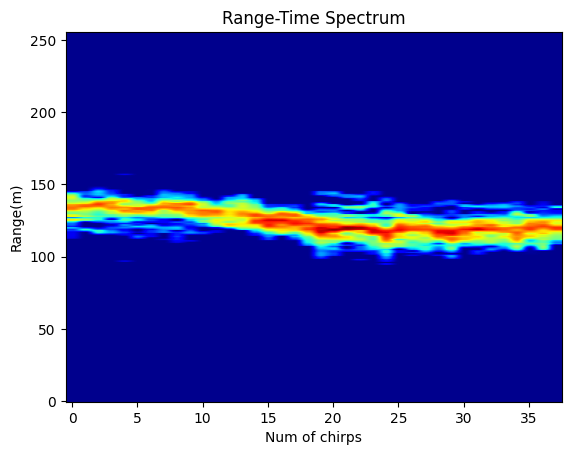

In [43]:
import time

start_time = time.time()

md, label= data_preprocessing('/kaggle/input/glasgow/2 March 2017 Dataset/1P03A01R2.dat')
print(label)
# md = np.load('/kaggle/working/processed_data/1_11_135_1_1.npz')['x']
print(md.shape)
md = 20*np.log10(np.abs(md))
# md = 20*np.log10(np.abs(md))
# md = (md-np.min(md))/(np.max(md)-np.min(md))
end_time = time.time()
execution_time = end_time - start_time
# md = md / (np.linalg.norm(md, axis=0, keepdims = True)+1e-8)
# md = (md-np.min(md))/(np.max(md)-np.min(md))
print(f"Execution Time: {execution_time:.4f} seconds")
print(md.shape)
im = plt.imshow(
    md, 
    aspect='auto', 
    cmap='jet', 
    origin='lower',
)
# plt.colorbar(label='Amplitude')
# plt.xlabel("Time")
# plt.ylabel("Velocity")
# plt.title("Micro-Doppler Spectrum")
clim = im.get_clim()
# im.set_clim(clim[1]*0.01, clim[1])
im.set_clim(clim[0], clim[1])
plt.xlabel("Num of chirps")
plt.ylabel("Range(m)")
plt.title("Range-Time Spectrum")
plt.show()

# md = md / (np.linalg.norm(md, axis=0, keepdims = True)+1e-8)

In [45]:
def process_all_files(input_root, output_root):
    for subdir, _, files in os.walk(input_root):
        for file in files:
            if file.endswith('.dat'):
                file_path = os.path.join(subdir, file)

                try:
                    micro_doppler, label = data_preprocessing(file_path)
                except Exception as e:
                    print(f"❌ Lỗi xử lý file {file_path}: {e}")
                    continue

                # Tạo đường dẫn lưu tương ứng
                relative_path = os.path.relpath(subdir, input_root)
                save_dir = os.path.join(output_root, relative_path)
                os.makedirs(save_dir, exist_ok=True)

                save_path = os.path.join(save_dir, file.replace(".dat", ".npz"))

                # Lưu file npz
                np.savez(save_path, micro_doppler=micro_doppler, label=label)

                print(f"✅ Đã lưu: {save_path}")

In [47]:
# input_root = "/kaggle/input/glasgow"
# output_root = "/kaggle/working/processed"

# process_all_files(input_root, output_root)

In [49]:
import os
import re
import shutil
import random
from collections import defaultdict

def extract_label_from_filename(filename):
    match = re.search(r'A(\d+)R', filename)
    return int(match.group(1)) if match else -1

def split_dataset_by_label(root_dir, output_base, train_ratio=0.7):
    label_to_files = defaultdict(list)

    # Bước 1: Duyệt và nhóm file theo label
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.npz'):
                label = extract_label_from_filename(file)
                full_path = os.path.join(subdir, file)
                label_to_files[label].append(full_path)

    # Bước 2: Chia train/test và lưu vào thư mục tương ứng
    for label, files in label_to_files.items():
        random.shuffle(files)  # shuffle ngẫu nhiên
        split_idx = int(len(files) * train_ratio)
        train_files = files[:split_idx]
        test_files = files[split_idx:]

        for split_name, split_files in [('train', train_files), ('test', test_files)]:
            save_dir = os.path.join(output_base, split_name)
            os.makedirs(save_dir, exist_ok=True)
            for fpath in split_files:
                fname = os.path.basename(fpath)
                save_path = os.path.join(save_dir, fname)
                shutil.copy(fpath, save_path)

    print("✅ Đã chia xong tập train/test.")



In [50]:
import os
import shutil

source_dir = '/kaggle/working/processed'
train_reference_dir = '/kaggle/input/glasgrow-noft/train'
test_reference_dir = '/kaggle/input/glasgrow-noft/test'

target_train_dir = '/kaggle/working/glasgrow_2/train'
target_test_dir = '/kaggle/working/glasgrow_2/test'

# Tạo thư mục đích nếu chưa có
os.makedirs(target_train_dir, exist_ok=True)
os.makedirs(target_test_dir, exist_ok=True)

# Lấy danh sách tên file từ thư mục train và test tham chiếu
train_filenames = set(os.listdir(train_reference_dir))
test_filenames = set(os.listdir(test_reference_dir))

# Hàm duyệt toàn bộ thư mục con
def copy_files_by_reference(source_dir, reference_filenames, target_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file in reference_filenames:
                src_path = os.path.join(root, file)
                dst_path = os.path.join(target_dir, file)
                shutil.copy2(src_path, dst_path)

# Sao chép file
copy_files_by_reference(source_dir, train_filenames, target_train_dir)
copy_files_by_reference(source_dir, test_filenames, target_test_dir)

print("✅ Đã sao chép các file train/test tương ứng từ thư mục processed.")


✅ Đã sao chép các file train/test tương ứng từ thư mục processed.


In [105]:
root_dir = "/kaggle/working/processed"
output_base = "/kaggle/working/dataset"

split_dataset_by_label(root_dir, output_base)


✅ Đã chia xong tập train/test.


(256, 38)
Execution Time: 0.0048 seconds
(256, 38)


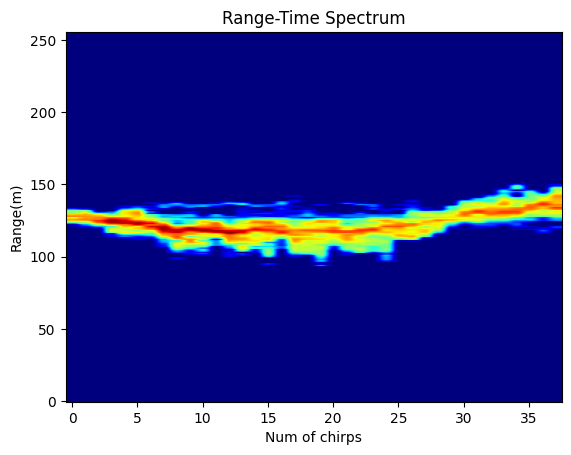

In [51]:
import time

start_time = time.time()

md = np.load('/kaggle/working/glasgrow_2/test/1P01A01R01.npz')['micro_doppler']
print(md.shape)
md = 20*np.log10(np.abs(md))
# md = 20*np.log10(np.abs(md))
# md = (md-np.min(md))/(np.max(md)-np.min(md))
end_time = time.time()
execution_time = end_time - start_time
# md = md / (np.linalg.norm(md, axis=0, keepdims = True)+1e-8)
# md = (md-np.min(md))/(np.max(md)-np.min(md))
print(f"Execution Time: {execution_time:.4f} seconds")
# print(md.shape)
# md = md[:,:,4000].T
print(md.shape)
im = plt.imshow(
    md, 
    aspect='auto', 
    cmap='jet', 
    origin='lower',
)
# plt.colorbar(label='Amplitude')
# plt.xlabel("Time")
# plt.ylabel("Velocity")
# plt.title("Micro-Doppler Spectrum")
clim = im.get_clim()
# im.set_clim(clim[1]*0.01, clim[1])
im.set_clim(clim[0], clim[1])
plt.xlabel("Num of chirps")
plt.ylabel("Range(m)")
plt.title("Range-Time Spectrum")
plt.show()

# md = md / (np.linalg.norm(md, axis=0, keepdims = True)+1e-8)

In [52]:
import shutil

dataset_dir = "/kaggle/working/glasgrow_2"
zip_file_path = "/kaggle/working/glasgrow_2"  # Không cần thêm .zip ở đây

# Tạo file dataset.zip từ thư mục dataset/
shutil.make_archive(zip_file_path, 'zip', dataset_dir)

print("✅ Đã nén thành công: dataset.zip")


✅ Đã nén thành công: dataset.zip
